In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
from sklearn.linear_model import LogisticRegression
from itertools import combinations_with_replacement, permutations, product
import multiprocessing.pool

<AxesSubplot:xlabel='PAY', ylabel='Count'>

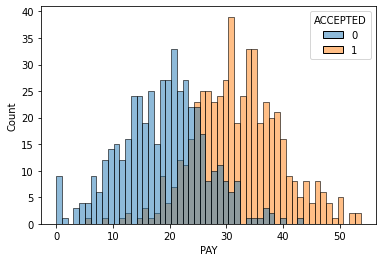

In [2]:
df = pd.read_csv('driverAcceptanceData.csv', index_col=0)
sns.histplot(df, x='PAY', hue='ACCEPTED', bins=53)

In [38]:
# model the rate of acceptance from price offered to drivers
model = LogisticRegression()
model.fit(df['PAY'].to_numpy().reshape(-1, 1), df['ACCEPTED'])
a = model.coef_[0][0]
b = model.intercept_[0]

In [129]:
### calculate profit per rider (from point of acquisition to month 12) ###
# price: array of price each month
# probs: array of acceptance rate each month
# return total profit and an array of lambda each month
def forward(price, probs):
    lmd = np.append(np.array([1]), np.cumprod(probs)[:-1])
    profits = lmd * probs * (30 - price) 
    return np.sum(profits), lmd



### calculate gradient descent ###
# price: array of price each month
# probs: array of acceptance rate each month
# lmd: an array of lambda each month
# return the array of gradients of total profit with respect to price each month.
def backward(price, probs, lmd):
    x = price
    n_month = len(x)
    
    # elemental gradients.
    dlogdx = a * np.exp(-a*x-b) * probs**2
    dPdx = lmd * (-1 - np.exp(-a*x-b) + a*(30-x)*np.exp(-a*x-b)) * probs**2
    dPdl = (30-x) * probs
    dldli = probs
    dldxi = lmd * dlogdx
    
    # get gradients of total profit with respect to price each month.
    dP = []
    for i in range(n_month):
        temp = dPdx[i]
        for j in range(i+1, n_month):
            temp = temp + dPdl[j] * np.product(dldli[i+1:j-1]) * dldxi[i]
        dP.append(temp)
    dP = np.array(dP)
    return dP



### get coef to counter gradient vanishing effect ###
# because month 12 profit << than month 1 profit, hence theirs derivatives.
# probs: array of acceptance rate each month
# return array of learning rate coef
def get_learning_rate_coef(probs):
    probs = 1/probs
    return np.append(np.array([1]), np.cumprod(probs)[:-1])



### get the maximum profit ###
# n_month: number of months from the point of acquisition to month 12
# return maximum profit and optimized price array
def optimize(n_month, alpha=0.1, gradient_thresh=0.00001):
    # initialize prices
    price = np.array([30]*n_month) 

    # get acceptance rate
    probs = model.predict_proba(np.array(price).reshape(-1, 1))[:, 1]
    
    # calculate profit
    profit, lmd = forward(price, probs)
    
    # calculate gradient
    dP = backward(price, probs, lmd)
    
    while (np.abs(dP[0]) > gradient_thresh):
        lr_coef = get_learning_rate_coef(probs)
        price = price * (1 + dP * lr_coef * alpha)
        probs = model.predict_proba(np.array(price).reshape(-1, 1))[:, 1]
        profit, lmd = forward(price, probs)
        dP = backward(price, probs, lmd)
        
    return profit, price

In [130]:
# get max profit for riders with different n_month
profits = []
for i in range(12, 0, -1):
    profit, _ = optimize(i)
    profits.append(profit)
profits = pd.DataFrame([range(12, 0, -1), profits]).T
profits.columns = ['n_months', 'max_profit']

# set acquisition month as month start
profits.index.name = 'month_start'
profits.index = profits.index + 1
profits

,n_months,max_profit
month_start,,
1,12.0,5.200822
2,11.0,5.196586
3,10.0,5.189685
4,9.0,5.178356
5,8.0,5.159600
6,7.0,5.128228
7,6.0,5.075235
8,5.0,4.982470
9,4.0,4.816914
